## Notebook Object
#### 1. Finds:
        - longest street
        - shortest street  
        - straightest street
        - curviest Street

       in Boulder,Colorado, USA
   
#### 2. Gives a function for above information in any cities (with OSMnx Relations)

#### Author: Boulder - Yu

In [2]:
import osmnx as ox
import shapely
import geopandas as gpd
import pandas as pd
import os
import matplotlib.pyplot as plt
import fiona
%pylab inline
import numpy as np
from collections import Counter
from geopy.distance import vincenty
from shapely.geometry import Point
import pylab as pl

Populating the interactive namespace from numpy and matplotlib


## Street Length

### 1.1 OSMnx Visualization

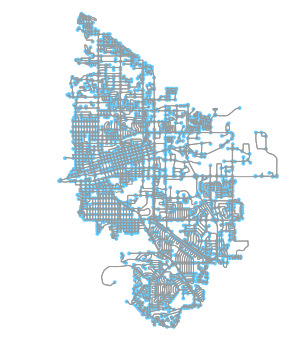

In [66]:
Boulder = ox.graph_from_place('Boulder, Colorado, USA',network_type='drive')
Boulder_projected = ox.project_graph(Boulder)
fig, ax = ox.plot_graph(Boulder_projected)

In [3]:
Boulder_stats = ox.basic_stats(Boulder)
Boulder_stats

{'circuity_avg': 1.0890808415549975,
 'clean_intersection_count': None,
 'clean_intersection_density_km': None,
 'edge_density_km': None,
 'edge_length_avg': 65.305853124113298,
 'edge_length_total': 1924628.7974207432,
 'intersection_count': 9327,
 'intersection_density_km': None,
 'k_avg': 5.474828162734535,
 'm': 29471,
 'n': 10766,
 'node_density_km': None,
 'self_loop_proportion': 0.006989922296494859,
 'street_density_km': None,
 'street_length_avg': 65.5917406772367,
 'street_length_total': 1048024.832540888,
 'street_segments_count': 15978,
 'streets_per_node_avg': 2.971019877391789,
 'streets_per_node_counts': {0: 0,
  1: 1439,
  2: 68,
  3: 6736,
  4: 2427,
  5: 84,
  6: 10,
  7: 1,
  8: 1},
 'streets_per_node_proportion': {0: 0.0,
  1: 0.13366152702953743,
  2: 0.006316180568456251,
  3: 0.6256734163106075,
  4: 0.22543191528887238,
  5: 0.007802340702210663,
  6: 0.0009288500835965075,
  7: 9.288500835965076e-05,
  8: 9.288500835965076e-05}}

In [67]:
ox.save_graph_shapefile(Boulder_projected, filename='boulder_osmnx')

In [22]:
streets_osmnx = gpd.read_file('data/boulder_osmnx/edges/edges.shp')
streets_osmnx.head()

,access,bridge,from,highway,key,lanes,length,maxspeed,name,oneway,osmid,ref,service,to,tunnel,width,geometry
0,None,None,25689292,tertiary,0,2,75.52249370416843,25 mph,Table Mesa Drive,False,8138094,None,None,25676629,None,None,LINESTRING (477469.8182809619 4425822.26872291...
1,None,None,176557033,tertiary,0,2,76.39418295406747,25 mph,Table Mesa Drive,False,8138097,None,None,25676629,None,None,LINESTRING (477469.8182809619 4425822.26872291...
2,None,None,176444092,residential,0,None,240.3226117193131,None,Hillsdale Way,False,17019278,None,None,25676629,None,None,LINESTRING (477316.7734638592 4425648.67808511...
3,None,None,515579248,residential,0,None,416.5636734359498,None,Hillsdale Circle,False,17027069,None,None,25676629,None,None,LINESTRING (477297.4870344754 4425972.89609869...
4,None,None,392990958,residential,0,None,34.539279419098094,None,Table Mesa Court,False,4279016,None,None,25676633,None,None,"LINESTRING (477788.620110429 4425602.76848329,..."


### 1.2 Combine Same Street Name

In [6]:
street = pd.DataFrame(streets_osmnx)

In [7]:
streets = pd.DataFrame(street.groupby(['name','length','highway','oneway'],as_index=False).size())
streets.reset_index(inplace=True)
streets.columns = ['name','length','highway','oneway','count']
streets.head()

,name,length,highway,oneway,count
0,10th Street,100.79694697432706,residential,False,1
1,10th Street,109.64105986877257,residential,False,1
2,10th Street,113.28416766646751,residential,False,1
3,10th Street,116.11034834399851,residential,True,1
4,10th Street,116.86861217792938,residential,False,1


In [8]:
streets.length = streets.length.astype(float)
streets.head()

,name,length,highway,oneway,count
0,10th Street,100.796947,residential,False,1
1,10th Street,109.641060,residential,False,1
2,10th Street,113.284168,residential,False,1
3,10th Street,116.110348,residential,True,1
4,10th Street,116.868612,residential,False,1


In [9]:
streets.highway.unique()

array(['residential', 'secondary', 'living_street', 'tertiary',
       'unclassified', "['residential', 'tertiary']", 'secondary_link',
       "['residential', 'secondary']", 'primary',
       "['primary', 'motorway']", 'motorway', 'trunk', 'motorway_link',
       "['living_street', 'residential']", 'tertiary_link',
       "['unclassified', 'residential']",
       "['living_street', 'unclassified']", "['unclassified', 'tertiary']"], dtype=object)

In [10]:
#way = streets[(streets.highway !='motorway')|(streets.highway !='trunk')]
#way.head()

### 1.3 Find Longest Street

In [11]:
street_length = streets.groupby('name')['length'].sum()
street_length = pd.DataFrame(street_length)
street_length.head()
street_length.loc[street_length['length'].idxmax()]

length    11448.64936
Name: Broadway, dtype: float64

In [12]:
#street_length.sort_values('length', ascending=False).head()

### 1.4 Find Shortest Street

In [13]:
street_length.loc[street_length['length'].idxmin()]

length    6.498745
Name: Bixby Lane, dtype: float64

In [14]:
#street_length.sort_values('length', ascending=True).head()

## Functions for street length

In [15]:
def howlong(place, ntype='drive'):
    """
    Find the shortest and longest roads by name in a given geographical area in OSM.
    
    Args:
        1. place: a string of place name
        2. ntype: network type (not tested yet)
    Return:
        1. name and length of the shortest road (length problem unsolved)
        2. name and length of the longest road (length problem unsolved)
        3. network graph plot of given place
    """
    
    # try different API query results
    try:
        G = ox.project_graph(ox.graph_from_place(place,network_type='drive', which_result=1))
    except:
        G = ox.project_graph(ox.graph_from_place(place, network_type='drive',which_result=2))
    
    # convert road segments as df
    segs = list(G.edges(data=True))

    df = pd.DataFrame([[i[0], i[1], i[2]['highway'], i[2]['length'],
                        i[2]['name'], i[2]['oneway'], i[2]['osmid']] for i in segs if 'name' in i[2]],
                      columns=['node_a', 'node_b', 'type', 'length',
                               'name', 'oneway', 'osmid'])
    df['name'] = df['name'].apply(lambda x: str(x))

    # combine road segments
    for j in df[df['oneway'] == False].index:
        df.loc[j,'length'] /= 2
    df2 = df.groupby(by='name').sum().reset_index()
    #df2.drop(['node_a', 'node_b', 'oneway'], axis=1, inplace=True)
    
    # calculate shortest and longest roads
    short = df2.loc[df2['length'].idxmin()]
    long = df2.loc[df2['length'].idxmax()]

    # output
    print('Shortest road: {:s} ({:.2f} meters)'.format(short['name'], short['length']))
    print('Longest road: {:s} ({:.2f} meters)'.format(long['name'], long['length']))

    ox.plot_graph(G);

Shortest road: Bixby Lane (6.50 meters)
Longest road: Broadway (11448.65 meters)


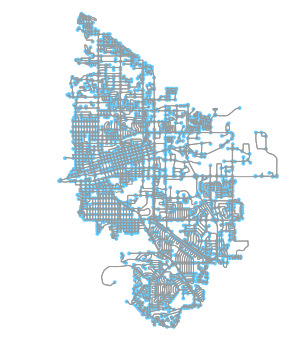

In [16]:
howlong('Boulder, Colorado, USA')

In [4]:
Boulder_stats = ox.basic_stats(ox.graph_from_place('Boulder, Colorado, USA'))
Boulder_stats['circuity_avg']

1.0890808415549975

In [5]:
place = 'Boulder, Colorado, USA'
gdf = ox.gdf_from_place(place)
area = ox.project_gdf(gdf).unary_union.area
G = ox.graph_from_place(place, network_type='drive_service')

In [6]:
# calculate basic and extended network stats, merge them together, and display
G_stats = ox.basic_stats(G, area=area)
extended_stats = ox.extended_stats(G, ecc=True, bc=True, cc=True)
for key, value in extended_stats.items():
    G_stats[key] = value
pd.Series(G_stats)

avg_neighbor_degree                    {25676629: 3.25, 25676633: 2.6666666666666665,...
avg_neighbor_degree_avg                                                          2.78012
avg_weighted_neighbor_degree           {25676629: 0.01607313599699411, 25676633: 0.07...
avg_weighted_neighbor_degree_avg                                               0.0473984
betweenness_centrality                 {25676629: 0.00183959307613052, 25676633: 0.00...
betweenness_centrality_avg                                                    0.00855371
center                                                                       [176538288]
circuity_avg                                                                     1.09697
clean_intersection_count                                                            None
clean_intersection_density_km                                                       None
closeness_centrality                   {25676629: 0.000159879942695, 25676633: 0.0001...
closeness_centrality_

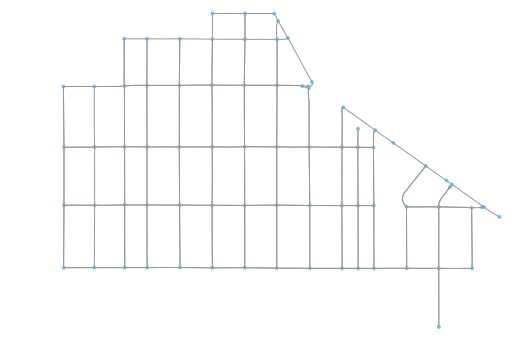

In [3]:
Universityhill = ox.graph_from_place('University hill,Boulder, Colorado, USA',network_type='drive')
Universityhill_projected = ox.project_graph(Universityhill)
fig, ax = ox.plot_graph(Universityhill_projected)

In [4]:
ox.save_graph_shapefile(Universityhill_projected, filename='Universityhill')

In [19]:
universityhill_osmnx = gpd.read_file('data/Universityhill/edges/edges.shp')
universityhill_osmnx.head()

,from,highway,key,lanes,length,maxspeed,name,oneway,osmid,ref,to,geometry
0,176400027,residential,0,None,73.84552645570908,None,Pennsylvania Avenue,True,17016730,None,176400030,LINESTRING (475930.1503303121 4428760.40782441...
1,5142433709,tertiary,0,2,157.40144975823097,25 mph,9th Street,False,111476648,None,176400027,LINESTRING (475931.0103233792 4428603.31852218...
2,176400030,residential,0,None,106.10529954939007,None,Pennsylvania Avenue,True,17016730,None,176400032,LINESTRING (476004.1473983456 4428759.99643543...
3,176492799,residential,0,None,155.01837018031637,None,Lincoln Place,False,506505467,None,176400030,LINESTRING (476003.7958258505 4428605.26399926...
4,176400032,residential,0,None,105.20437832804623,None,Pennsylvania Avenue,True,17016730,None,176400034,LINESTRING (476110.4763638941 4428760.01691078...


In [20]:
universityhill_streets = pd.DataFrame(universityhill_osmnx.groupby(['name','highway','from','to'],as_index=False).size())
universityhill_streets.reset_index(inplace=True)
universityhill_streets.columns = ['name','highway','from','to','count']
universityhill_streets.head()

,name,highway,from,to,count
0,10th Street,residential,176492329,176439760,1
1,10th Street,residential,176492800,176400032,1
2,10th Street,residential,176539314,176492329,1
3,10th Street,residential,176539314,176492800,1
4,11th Street,residential,176400034,176526885,1


In [12]:
ulist = list(universityhill_streets['from'].values) + list(universityhill_streets['to'].values)
udict = dict(Counter(ulist))
udict

{'1195133744': 1,
 '1203601478': 4,
 '1203601542': 1,
 '1203601684': 3,
 '1203601699': 4,
 '176400027': 2,
 '176400030': 3,
 '176400032': 3,
 '176400034': 4,
 '176400036': 4,
 '176400038': 4,
 '176439746': 2,
 '176439750': 3,
 '176439754': 3,
 '176439756': 3,
 '176439760': 3,
 '176439761': 3,
 '176439762': 3,
 '176439766': 3,
 '176439768': 3,
 '176439770': 3,
 '176439772': 3,
 '176439774': 3,
 '176439776': 4,
 '176439780': 2,
 '176488611': 3,
 '176488613': 3,
 '176488617': 2,
 '176491034': 4,
 '176491036': 4,
 '176492295': 3,
 '176492299': 4,
 '176492302': 3,
 '176492325': 4,
 '176492327': 4,
 '176492329': 4,
 '176492334': 4,
 '176492336': 4,
 '176492338': 4,
 '176492340': 4,
 '176492342': 4,
 '176492796': 3,
 '176492799': 4,
 '176492800': 4,
 '176492801': 4,
 '176492802': 4,
 '176492813': 2,
 '176495108': 4,
 '176526885': 2,
 '176526887': 3,
 '176534140': 1,
 '176539309': 4,
 '176539314': 4,
 '176539316': 4,
 '176539322': 4,
 '176539325': 4,
 '176539332': 4,
 '2047280703': 3,
 '204732

In [13]:
# nodes =1 imply that they are the origin and destination
head = pd.DataFrame(list(udict.items()), columns=['node', 'count'])
headtoe = head[head['count']==1]
headtoe

,node,count
27,176534140,1
60,2047329110,1
72,1203601542,1
75,544818007,1
76,1195133744,1


In [14]:
university_nodes = gpd.read_file('data/Universityhill/nodes/nodes.shp')
university_nodes.head()

,highway,lat,lon,osmid,geometry
0,None,40.0086954,-105.282017,176400027,POINT (475930.1503303121 4428760.407824418)
1,None,40.0086938,-105.28115,176400030,POINT (476004.1473983456 4428759.996435432)
2,None,40.008697,-105.2799042,176400032,POINT (476110.4763638941 4428760.016910787)
3,None,40.008691,-105.278669,176400034,POINT (476215.8974247478 4428759.020587706)
4,None,40.008689,-105.277433,176400036,POINT (476321.3881634401 4428758.469475747)


In [29]:
university_nodes_or = university_nodes[list(map(lambda n: n in list(udict.keys()), list(university_nodes['osmid'])))]

In [18]:
university_nodes_term = university_nodes[list(map(lambda n: n in list(headtoe['node'].values), list(university_nodes['osmid'])))]
university_nodes_term

,highway,lat,lon,osmid,geometry
45,None,40.0000897,-105.2700429,176534140,POINT (476949.234371375 4427802.091337437)
53,traffic_signals,40.0033912,-105.2677565,544818007,POINT (477145.5016915529 4428167.937590278)
62,None,40.0074181,-105.274884,1195133744,POINT (476538.507821372 4428616.737379371)
64,None,40.0060209,-105.2731338,1203601542,POINT (476687.4132424186 4428461.202079194)
69,None,40.0072839,-105.2750215,2047329110,POINT (476526.7261448975 4428601.878649102)


Supposedly we are expecting only two nodes (one as the origin, one as the destination）, but this has multiple origin and/or destination.

![](radroad.PNG)

this needs to be further discussed, for now we will be considering two nodes streets

## Function for street curviness

In [2]:
def howcurve(place, ntype='drive'):
    """
    Find the straightest and curviest roads by name in a given geographical area in OSM.
    
    Args:
        1. place: a string of place name
        2. ntype: network type (not tested yet)
    Return:
        1. name and circuity info of the straightest road
        2. name and circuity info of the curviest road
        3. network graph plot of given place
    """
    
    # try different API query results
    try:
        G = ox.graph_from_place(place, network_type='drive', which_result=1)
    except:
        G = ox.graph_from_place(place, network_type='drive', which_result=2)
    
    # save and read as .shp file
    ox.save_graph_shapefile(G, filename='howcurve')
    G_edges = gpd.read_file('data/howcurve/edges/edges.shp')
    G_nodes = gpd.read_file('data/howcurve/nodes/nodes.shp')
    
    # extract road names
    roads = list(G_edges['name'].unique())
    #roads.remove('') ### remove messy segements without names ###
    rnames = []
    dist_v = []
    dist_r = []
    circuity = []
    
    # calculate circuity for each road
    for i,r in enumerate(roads):
        df_road = G_edges[G_edges['name'] == roads[i]]
        nor = list(df_road['from'].values) + list(df_road['to'].values)
        tdict = dict(Counter(nor))
        tdf = pd.DataFrame(list(tdict.items()), columns=['node', 'count'])
        tdf_sub = tdf[tdf['count']==1]

        if len(tdf_sub) != 2:
            
            continue ### skip roads with more than two terminal nodes for now ###

        else:
            
            G_nodes_term = G_nodes[list(map(lambda n: n in list(tdf_sub['node'].values), list(G_nodes['osmid'])))]
            coord1 = list(G_nodes_term.iloc[0,:]['geometry'].coords)[0]
            coord2 = list(G_nodes_term.iloc[1,:]['geometry'].coords)[0]
            p1 = coord1[1], coord1[0]
            p2 = coord2[1], coord2[0]

            d_v = vincenty(p1, p2).meters
            d_r = df_road['length'].astype('float', error='coerce').sum()
            circ = d_r / d_v

            rnames.append(r)
            dist_v.append(d_v)
            dist_r.append(d_r)
            circuity.append(circ)

    # create a dataframe with circuity data
    df_circ = pd.DataFrame({'name': rnames,
                            'dist_v': dist_v,
                            'dist_r': dist_r,
                            'circuity': circuity})

    # calculate straightest and curviest roads
    straight = df_circ.sort_values('circuity', ascending=True).head(1).iloc[0]
    curve = df_circ.sort_values('circuity', ascending=False).head(1).iloc[0]
    
    # output
    print('Straightest road: {:s}\nroad dist.: {:.2f}\nshortest dist.: {:.2f}\ncircuity: {:.5f}\n'.format(straight['name'], straight['dist_r'], straight['dist_v'], straight['circuity']))
    print('Curviest road: {:s}\nroad dist.: {:.2f}\nshortest dist.: {:.2f}\ncircuity: {:.5f}\n'.format(curve['name'], curve['dist_r'], curve['dist_v'], curve['circuity']))

    #ox.plot_graph(G);
    fig, ax = pl.subplots(figsize=(10,10))
    G_edges.plot(ax=ax)
    G_edges[G_edges['name'] == straight['name']].plot(color='red', ax=ax, label='straightest')
    G_edges[G_edges['name'] == curve['name']].plot(color='orange', ax=ax, label='curviest')
    pl.legend(fontsize='medium')
    pl.show()

Straightest road: Bixby Lane
road dist.: 6.50
shortest dist.: 6.52
circuity: 0.99745

Curviest road: South Broadway
road dist.: 5473.86
shortest dist.: 10.81
circuity: 506.32474



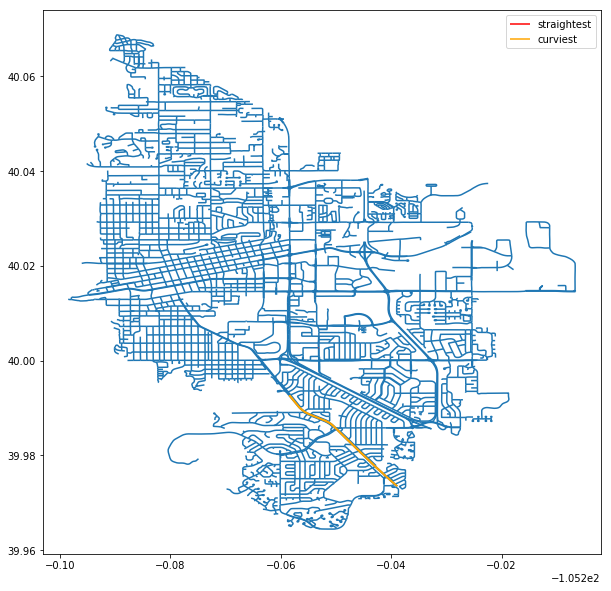

In [3]:
howcurve('Boulder, CO')

## Explore Nominatim forDetails

In [55]:
from geopy import Nominatim

In [56]:
geolocator = Nominatim()
location = geolocator.geocode("Broadway,Boulder,Colorado")
print(location.address)
print(location.raw)

Broadway, The Hill, Boulder, Boulder County, Colorado, 80309, United States of America
{'place_id': '163759479', 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://www.openstreetmap.org/copyright', 'osm_type': 'way', 'osm_id': '420432642', 'boundingbox': ['39.9966112', '39.9979125', '-105.2619956', '-105.2610971'], 'lat': '39.9967495', 'lon': '-105.2611941', 'display_name': 'Broadway, The Hill, Boulder, Boulder County, Colorado, 80309, United States of America', 'class': 'highway', 'type': 'primary', 'importance': 0.355}


In [75]:
location = geolocator.geocode("Bixby Lane,Boulder,Colorado")
print(location.address)
print(location.raw)

Bixby Lane, Boulder, Boulder County, Colorado, 80303, United States of America
{'place_id': '69503821', 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://www.openstreetmap.org/copyright', 'osm_type': 'way', 'osm_id': '17019546', 'boundingbox': ['40.002702', '40.002741', '-105.255933', '-105.2530868'], 'lat': '40.0027399', 'lon': '-105.2554139', 'display_name': 'Bixby Lane, Boulder, Boulder County, Colorado, 80303, United States of America', 'class': 'highway', 'type': 'residential', 'importance': 0.445}
